<a href="https://colab.research.google.com/github/abinashregmi/nepal-economic-dashboard/blob/main/LastResort_Economic_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project: Data-Driven Analysis of Nepal's Economic Resilience 🇳🇵**


This project will show you through a data science workflow, from data acquisition to building a predictive model and an interactive dashboard. I will be analyzing key economic indicators for Nepal to understand their trends and build a model to predict future economic resilience.

**1. Data Acquisition and Merging**

First, we need to import the necessary libraries and load our csv file. For this project, we will need to download the data from the sources like CEIC Data, World Bank Open Data, and Open Data Nepal. For this example, we'll use placeholder CSV files named tourism_revenue.csv.csv, world_bank_data.csv.csv, and open_data_nepal.csv.csv.

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import joblib

*Loads datasets from CSV files, cleans them, and merges them into a single DataFrame.*

In [ ]:
def load_and_merge_data():
    # Load the datasets, skipping the unrequired rows
    try:
        tourism_df_raw = pd.read_csv('tourism_revenue.csv.csv', skiprows=4)
        world_bank_df_raw = pd.read_csv('world_bank_data.csv.csv', skiprows=4)
        open_data_nepal_df_raw = pd.read_csv('open_data_nepal.csv.csv', skiprows=4)
        print("Successfully loaded data from local CSV files.")
    except FileNotFoundError:
        print("One or more CSV files not found. Returning empty DataFrame.")
        return pd.DataFrame()

    # Define the columns we are going to target
    tourism_col_map = {'International tourism, receipts (current US$)': 'Tourism Revenue (USD mn)'}
    world_bank_col_map = {
        'GDP (current US$)': 'GDP (current US$)',
        'Personal remittances, received (% of GDP)': 'Personal Remittances (% of GDP)'
    }
    unemployment_col_map = {'Unemployment, total (% of total labor force) (modeled ILO estimate)': 'Unemployment Rate'}

    # function to clean and reshape the data
    def clean_and_reshape(df, column_map):
        df_clean = df.drop(columns=['Country Name', 'Country Code', 'Indicator Code']).set_index('Indicator Name').T
        df_clean.index.name = 'Year'
        df_clean = df_clean.rename(columns=column_map)
        df_clean = df_clean.loc[:, list(column_map.values())] # Select only the renamed columns
        df_clean = df_clean.reset_index()
        df_clean['Year'] = pd.to_numeric(df_clean['Year'], errors='coerce')
        return df_clean

    # Clean and reshape each DataFrame
    tourism_df = clean_and_reshape(tourism_df_raw, tourism_col_map)
    world_bank_df = clean_and_reshape(world_bank_df_raw, world_bank_col_map)
    open_data_nepal_df = clean_and_reshape(open_data_nepal_df_raw, unemployment_col_map)

    # Merge the dataframes on the 'Year' column
    merged_df = pd.merge(tourism_df, world_bank_df, on='Year', how='outer')
    merged_df = pd.merge(merged_df, open_data_nepal_df, on='Year', how='outer')
    merged_df = merged_df.sort_values('Year').reset_index(drop=True)

    print("Merged DataFrame head:")
    print(merged_df.head())
    print("" * 40 + "\n")
    return merged_df

**2. Data Cleaning and Preprocessing (Week 1)**

Here I will handle missing values, duplicates, and create new features to improve our dataset, ensuring the quality of our data.

In [ ]:
def clean_and_preprocess(df):
    print("Missing values before cleaning:")
    print(df.isnull().sum())

    # Handle missing values using forward fill and back fill for time-series
    df.ffill(inplace=True)
    df.ffill(inplace=True)

    # Check for duplicates
    print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")
    df.drop_duplicates(inplace=True)

    # Feature Engineering
    print("\nPerforming Feature Engineering...")
    # Creating 'Remittance-to-Tourism Ratio'
    df['Remittance_to_Tourism_Ratio'] = df['Personal Remittances (% of GDP)'] / df['Tourism Revenue (USD mn)']

    # Calculate 'Year-on-Year GDP Growth Rate'
    df['GDP_Growth_Rate'] = df['GDP (current US$)'].pct_change() * 100

    # Clean up any infinite values
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True) # Drop rows with NaN, especially the first year

    print("DataFrame after cleaning:")
    print(df.head())
    print("" * 40 + "\n")
    return df


**3. Exploratory Data Analysis (EDA) & Visualization (Week 2)**

Now, let's explore the data to find patterns and correlations. We will use matplotlib and seaborn to create visualizations.

In [ ]:
def perform_eda(df):
    sns.set(style="whitegrid", font_scale=1.1)  # Setting the style for the plots

    # Time-series plot for Tourism Revenue and GDP
    fig, ax1 = plt.subplots(figsize=(14, 7))
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Tourism Revenue (USD mn)', color='tab:blue')
    ax1.plot(df['Year'], df['Tourism Revenue (USD mn)'], color='tab:blue', marker='o', label='Tourism Revenue (USD mn)')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('GDP (current US$)', color='tab:green')
    ax2.plot(df['Year'], df['GDP (current US$)'], color='tab:green', marker='x', linestyle='--', label='GDP (current US$)')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    plt.title("Nepal's Tourism Revenue and GDP Over Time", fontsize=16)
    fig.tight_layout()
    plt.savefig('tourism_gdp_timeseries.png')
    plt.show()
    print("\n\nGenerated and saved tourism_gdp_timeseries.png\n")

    # Scatter plot for Remittances and GDP Growth
    plt.figure(figsize=(12, 7))
    sns.regplot(x='Personal Remittances (% of GDP)', y='GDP_Growth_Rate', data=df)
    plt.title('Relationship between Remittances and GDP Growth Rate', fontsize=16)
    plt.xlabel('Personal Remittances (% of GDP)')
    plt.ylabel('GDP Growth Rate (%)')
    plt.savefig('remittances_gdp_growth_scatter.png')
    plt.show()
    print("\n\nGenerated and saved remittances_gdp_growth_scatter.png\n")


    # Correlation Heatmap
    plt.figure(figsize=(12, 10))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix of Economic Indicators', fontsize=16)
    plt.savefig('correlation_heatmap.png')
    plt.show()
    print("\n\nGenerated and saved correlation_heatmap.png")
    print("" * 40 + "\n")

**4. Statistical Inference and Machine Learning (Week 3)**

Here, I will build a predictive model. I wil be using a Linear Regression model for predicting a continuous variable like GDP growth.

**Hypothesis:** An increase in tourism revenue and personal remittances leads to a subsequent increase in GDP growth.

In [ ]:
def build_and_evaluate_model(df):
    # Define features (X) and target (y)
    features = ['Tourism Revenue (USD mn)', 'Personal Remittances (% of GDP)', 'Unemployment Rate']
    target = 'GDP_Growth_Rate'

    X = df[features]
    y = df[target]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Testing set size: {X_test.shape[0]} samples")

    # Create and train the Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = model.score(X_test, y_test)

    print(f"\nModel Evaluation:")
    print(f"  Mean Squared Error (MSE): {mse:.2f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"  R-squared (R²): {r2:.2f}")


    # Print the model coefficients
    print("\n\nModel Coefficients (Feature Importance):")
    for feature, coef in zip(features, model.coef_):
        print(f"  - {feature}: {coef:.4f}")

    # the trained model for the Streamlit app
    joblib.dump(model, 'gdp_growth_model.pkl')
    print("\n\nSuccessfully trained and saved the model to gdp_growth_model.pkl")
    print("" * 40 + "\n")

*Executing the main program*

Successfully loaded data from local CSV files.
Merged DataFrame head:
Indicator Name    Year  Tourism Revenue (USD mn)  GDP (current US$)  \
0               1960.0                       NaN       5.083344e+08   
1               1961.0                       NaN       5.319596e+08   
2               1962.0                       NaN       5.740911e+08   
3               1963.0                       NaN       4.969479e+08   
4               1964.0                       NaN       4.960988e+08   

Indicator Name  Personal Remittances (% of GDP)  Unemployment Rate  
0                                           NaN                NaN  
1                                           NaN                NaN  
2                                           NaN                NaN  
3                                           NaN                NaN  
4                                           NaN                NaN  


Missing values before cleaning:
Indicator Name
Year                                1
To

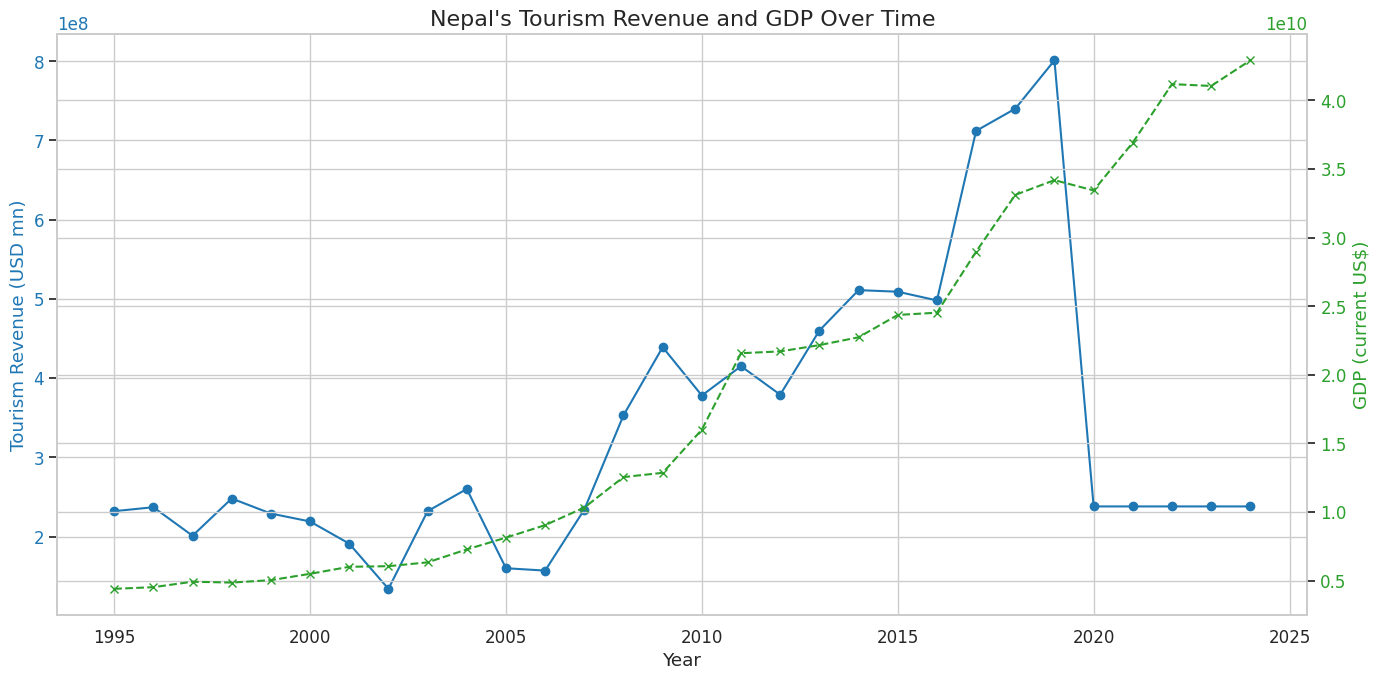



Generated and saved tourism_gdp_timeseries.png



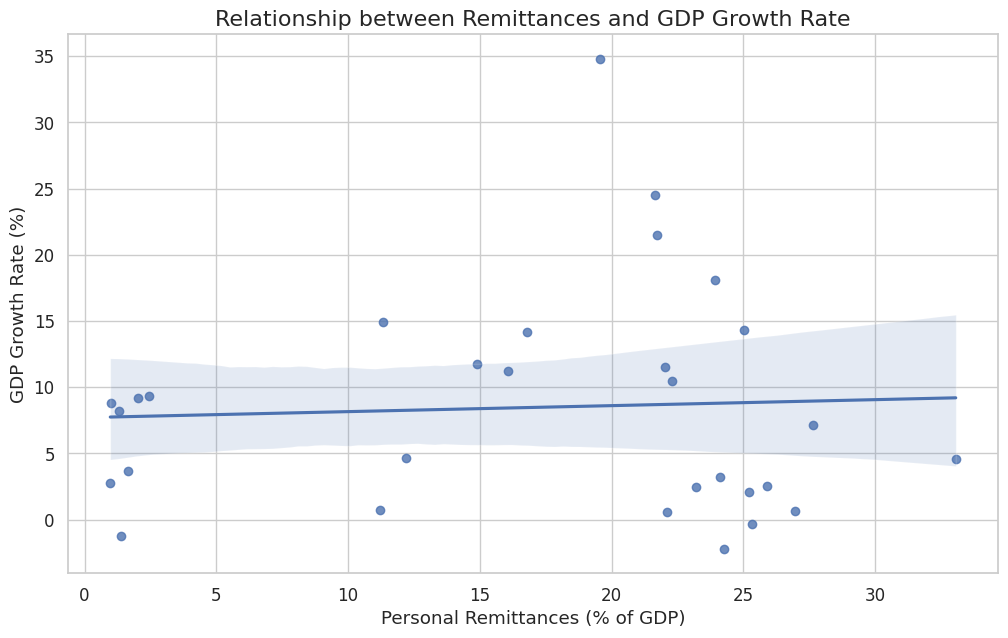



Generated and saved remittances_gdp_growth_scatter.png



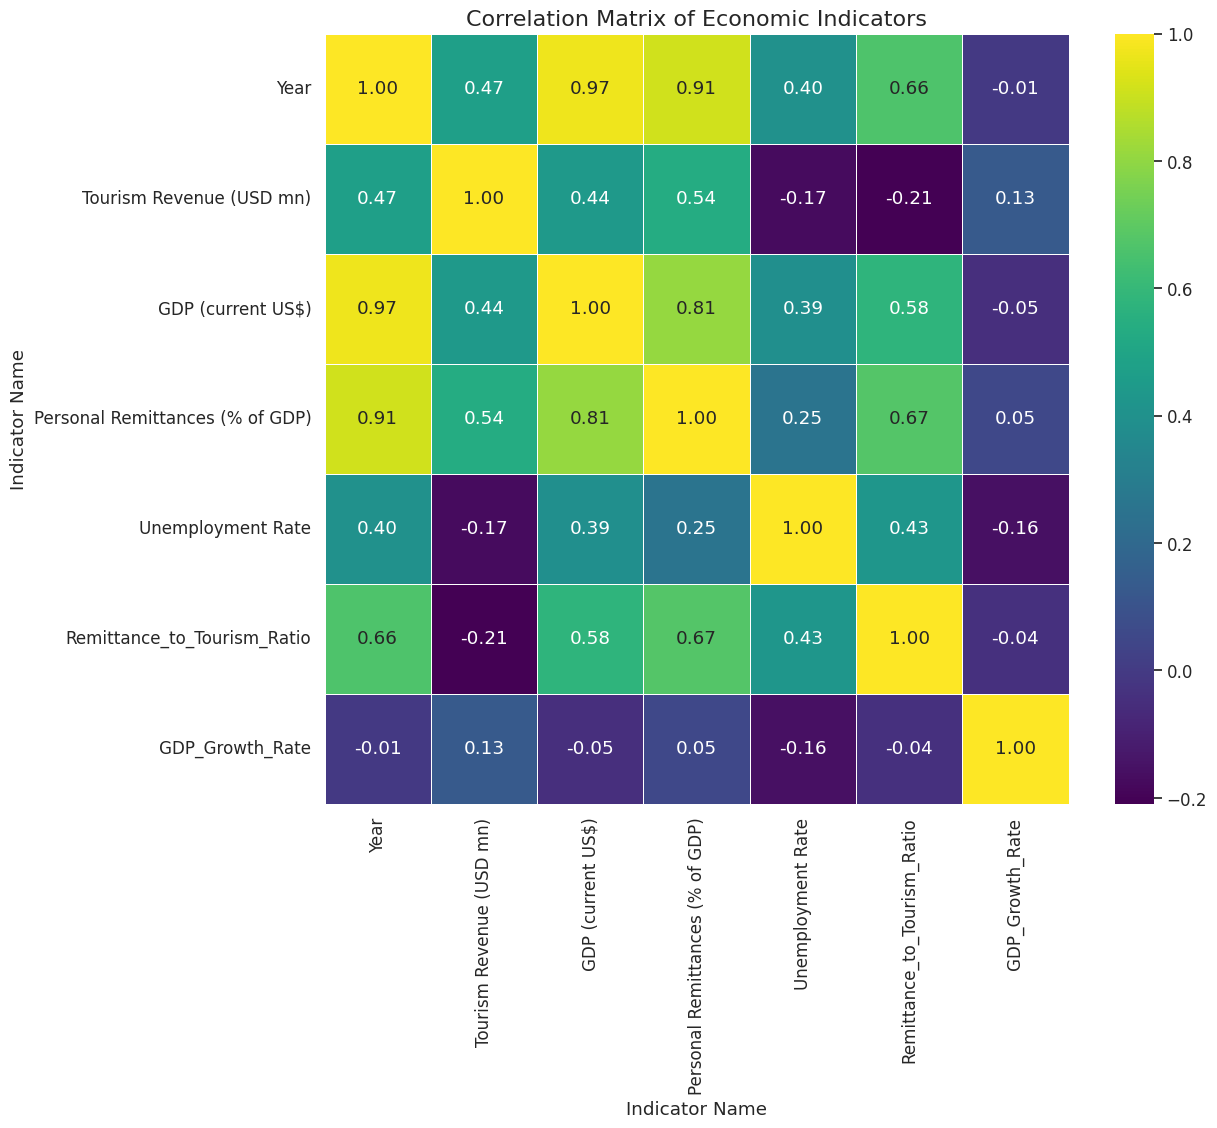



Generated and saved correlation_heatmap.png


Training set size: 24 samples
Testing set size: 6 samples

Model Evaluation:
  Mean Squared Error (MSE): 70.37
  Root Mean Squared Error (RMSE): 8.39
  R-squared (R²): -0.19


Model Coefficients (Feature Importance):
  - Tourism Revenue (USD mn): 0.0000
  - Personal Remittances (% of GDP): 0.0266
  - Unemployment Rate: -2.2075


Successfully trained and saved the model to gdp_growth_model.pkl


Analysis complete.


In [ ]:
if __name__ == '__main__':
    economic_data = load_and_merge_data()
    cleaned_data = clean_and_preprocess(economic_data)
    perform_eda(cleaned_data)
    build_and_evaluate_model(cleaned_data)
    print("Analysis complete.")